In [53]:
import numpy
import cv2
img = numpy.array(cv2.imread('UTS_Satellite.jpg'))[...,::-1]/255.0

In [54]:
import torch

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [55]:
import utils
import torchvision

model = torchvision.models.vgg16(pretrained=True); model.eval()
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

In [75]:
print(model._modules)

OrderedDict([('features', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): 

In [56]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

In [57]:
scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

       jigsaw puzzle (611):  8.220
bookshop, bookstore, (454):  7.611
            cassette (481):  7.135
container ship, cont (510):  7.088
             library (624):  6.767
          comic book (917):  6.720
cab, hack, taxi, tax (468):  5.975
     maze, labyrinth (646):  5.683
tobacco shop, tobacc (860):  5.591
hard disc, hard disk (592):  5.346


In [58]:
# We will be implementing LRP-epsilon to test
# This rule can be implemented in a series of 4 steps
#
# Step 1: zk = epsilon + sum(0,j)(activationj * rho*(biasjk))
# Step 2: sk = Relevance(Rk) / zk
# Step 3: cj = sum(k)(rho*(biasjk)*sk)
# Step 4: Relevance(Rj) = aj * cj

In [62]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==611).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]

In [76]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)
    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
        
        if l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        if 17 <= l <= 30:
            rho = lambda p: p
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:
            rho = lambda p: p;
            incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l])) # Step 1
        s = (R[l+1]/z).data # Step 2
        (z*s).sum().backward(); c = A[l].grad # Step 3
        R[l] = (A[l]*c).data # Step 4
        
    else:
        R[l] = R[l+1]

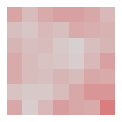

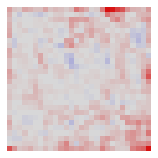

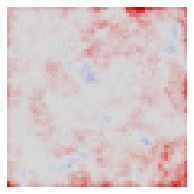

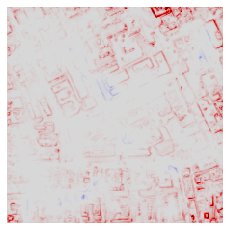

In [64]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [65]:
# To make use of the first layer with the given rule, we must implement a series of forward passes
# and gradient computations


A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

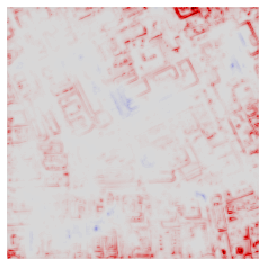

In [66]:
utils.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)